# Code

In [14]:
import pandas as pd
import os
import time
import numpy as np
import sys
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '..')
import dataset.preprocessing as utils
from config import *

### Pre-processing

In [2]:
df_hub = utils.read_dataframe(os.path.join(original_files_dir, 'hub.table.paris.txt'), columns_to_drop = ['Unnamed: 0','gene_name']).rename({'cell_line': 'cell_line_set',
                                                                                                                                                    'degree':'n_interactors',
                                                                                                                                                    'gene_type': 'gene_type_set',
                                                                                                                                                    'species': 'species_set'}, axis = 1)
tx = utils.read_dataframe(os.path.join(original_files_dir,'tx_regions.ens99.txt'), columns_to_drop = ['Unnamed: 0','ensembl_transcript_id']).rename({'ensembl_gene_id': 'gene_id'}, axis = 1)
cc = utils.read_dataframe(os.path.join(original_files_dir,'controls_controlled.hub.txt'), columns_to_drop = ['Unnamed: 0'])
int_or = utils.read_dataframe(os.path.join(original_files_dir, 'rise_paris_tr.new.mapped_interactions.tx_regions.txt'), columns_to_drop = ['Unnamed: 0',  'Unnamed: 0.1', 'gene_name1', 'gene_name2', 'score', 'tx_id_1', 'tx_id_2', 'rise_id', 'type_interaction', 'tx_id_1_localization', 'tx_id_2_localization'])
int_or = int_or.drop_duplicates().reset_index(drop = True)
df_genes = df_hub.merge(tx, on = 'gene_id')
assert df_genes.shape[0] == df_hub.shape[0]

In [3]:
df_pairs_full = utils.obtain_df_pos_controls(cc)[['positive']].drop_duplicates().reset_index(drop = True)

In [4]:
rgx = df_pairs_full['positive'].str.extractall('(.*)_(.*)').reset_index(drop = True)
df_pairs_full['gene1'], df_pairs_full['gene2'] = rgx[0], rgx[1]

In [5]:
how_many_negatives_per_positive = 2 
for i in range(how_many_negatives_per_positive):
    df_pairs_full['gene2'] = df_pairs_full.sample(frac=1, replace=False, random_state=42).reset_index(drop = True)['gene2']
    df_pairs_full[f'negative{i}'] = df_pairs_full['gene1'] + '_' + df_pairs_full['gene2']
    
df_pairs_full = pd.concat([
    df_pairs_full[['positive', 'negative0']].rename({'negative0':'negative'}, axis = 1),
    df_pairs_full[['positive', 'negative1']].rename({'negative1':'negative'}, axis = 1)
], axis = 0)

def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)

df_pairs_full['negative'] = df_pairs_full['negative'].apply(order_genes)
df_pairs_full['positive'] = df_pairs_full['positive'].apply(order_genes)

In [6]:
to_drop = set(df_pairs_full['positive']).intersection(df_pairs_full['negative'])

print('how many to drop', len(to_drop))

df_pairs_full = df_pairs_full[~df_pairs_full['negative'].isin(to_drop)]

how many to drop 546


In [7]:
print(f'We have {len(set(df_pairs_full.positive))} pairs interacting (they can have multiple interactions) \n')
print(f'We have {len(set(df_pairs_full.negative))} pairs not interacting \n')

We have 80485 pairs interacting (they can have multiple interactions) 

We have 159687 pairs not interacting 



In [8]:
df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM.csv'), index = False)

In [9]:
df_neg = df_pairs_full[['negative']].drop_duplicates().reset_index(drop = True)
df_neg[['gene1', 'gene2']] = df_neg['negative'].str.split('_', expand = True)
df_neg = df_neg.rename({'negative':'couples'}, axis = 1)

### Gene info df

In [10]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

### Clean bounding boxes of df interactions

In [11]:
df_int = pd.read_csv(os.path.join(processed_files_dir, 'full_paris_info_interactions.csv'))

df_int = df_int[['couples', 'gene1', 'gene2', 
                 'interacting', 'length_1', 'length_2',
                 'protein_coding_1', 'protein_coding_2',
                 'x1', 'y1', 'w', 'h']]

In [12]:
df_neg['interacting'] = False
df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_1','protein_coding':'protein_coding_1'} , axis = 1)
df_neg = df_neg.merge(df_genes[['gene_id', 'length', 'protein_coding']], left_on = 'gene2', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_2','protein_coding':'protein_coding_2'} , axis = 1)

In [14]:
assert (set(df_pairs_full.negative) - set(df_neg.couples) == {np.nan})|(set(df_pairs_full.negative) - set(df_neg.couples) == set()) # I have some NaN in the df_pairs_full

In [15]:
df_int1 = df_int[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1',  'w': 'l'}, axis = 1)
df_int2 = df_int[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1',  'h': 'l'}, axis = 1)
df_coord = pd.concat([df_int1, df_int2], ignore_index = True)#.drop_duplicates().reset_index(drop = True)
#df_coord may have duplicates. but this is something I want. If a gene appears more than once, I want it to be sampled according to its distribution.

In [16]:
assert set(df_neg.gene1).union(set(df_neg.gene2)) - set(df_coord.gene) == set()

### Create fake negative interactions

In [17]:
df_coord = df_coord.merge(
    df_genes.filter(['gene_id', 'UTR5', 'CDS', 'UTR3', 'protein_coding'], axis = 1).rename({'gene_id':'gene'}, axis = 1)
)
df_coord['where_c1'] = df_coord.apply(utils.where_interacts, axis = 1)

In [18]:
#127 min
start_time = time.time()
new_cols = df_neg[['couples', 'gene1', 'gene2']].apply(utils.create_fake_coord_neg, axis = 1, args = (df_coord,df_pairs_full,df_int,))
print(f"Total time: {(time.time()-start_time)/60} minutes")

Total time: 127.97081159353256 minutes


In [19]:
new_cols = new_cols.apply(pd.Series).rename({0:'x1', 1:'y1', 2:'w', 3:'h'}, axis = 1)

In [20]:
df_neg = pd.concat([df_neg, new_cols], axis = 1)

In [21]:
df = pd.concat([df_int, df_neg], ignore_index = True, axis = 0)
df.to_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'), index = False)

Now I do checks

In [22]:
#check if it worked
assert (df_neg.x1 <= df_neg.length_1).all()
assert ((df_neg.x1 + df_neg.w) <= df_neg.length_1).all()
assert (df_neg.y1 <= df_neg.length_2).all()
assert ((df_neg.y1 + df_neg.h) <= df_neg.length_2).all()

In [23]:
# 37 min
#check if it worked
start_time = time.time()
for _, row in df_neg.iterrows():
    g1 = row.gene1
    g2 = row.gene2
    assert [row.x1, row.w] in df_coord[df_coord.gene == g1][['c1', 'l']].values
    assert [row.y1, row.h] in df_coord[df_coord.gene == g2][['c1', 'l']].values
    if np.random.rand() < 0.0003: #progress
        print(f"{np.round(_/df_neg.shape[0] * 100, 2)}% in {(time.time()-start_time)/60} minutes")
print(f"Total time: {(time.time()-start_time)/60} minutes")

0.49% in 0.2674432396888733 minutes
1.28% in 0.6839573502540588 minutes
8.14% in 4.317260754108429 minutes
9.92% in 5.259678407510122 minutes
12.7% in 6.731126554807028 minutes
13.63% in 7.224628718694051 minutes
15.42% in 8.172607183456421 minutes
19.99% in 10.593974514802296 minutes
24.2% in 12.827969026565551 minutes
25.07% in 13.286136547724405 minutes
29.36% in 15.51808332602183 minutes
29.55% in 15.614556908607483 minutes
29.64% in 15.656647749741872 minutes
30.76% in 16.20518857638041 minutes
39.27% in 20.353888646761575 minutes
41.51% in 21.44532863299052 minutes
42.41% in 21.88201893965403 minutes
42.77% in 22.05802938143412 minutes
44.75% in 23.02445451418559 minutes
51.54% in 26.332193080584208 minutes
51.82% in 26.468093542257943 minutes
54.11% in 27.58557262420654 minutes
56.94% in 29.00339949131012 minutes
66.4% in 34.024077320098876 minutes
67.42% in 34.567647349834445 minutes
70.07% in 35.96970264116923 minutes
72.13% in 37.05869233210881 minutes
77.01% in 39.6492141405

# Plots 

### Degree

In [2]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv'))

In [37]:
def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [38]:
gene_count = obtain_gene_count_real(df)

In [77]:
gene_count[gene_count['diff']>10].shape[0]

45

In [78]:
gene_count[gene_count['diff']>100].shape[0]

2

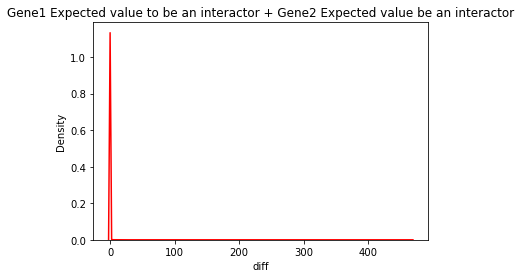

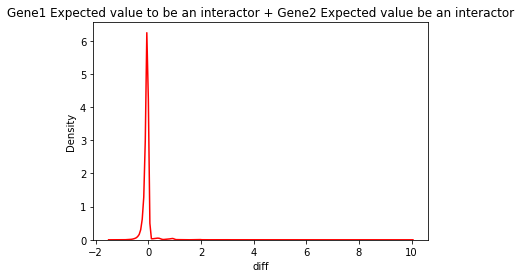

In [79]:
sns.kdeplot(gene_count['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

sns.kdeplot(gene_count[gene_count['diff']<10]['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

### CDS-CDS enrichment?

In [38]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df_RANDOM.csv')) #final_df_RANDOM

In [28]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))[['gene_id', 'CDS', 'UTR5', 'UTR3']]

In [29]:
def create_interactions_columns(df, df_genes):

    df = df.merge(df_genes, left_on = 'gene1', right_on = 'gene_id')
    df['where_x1'] = 'none'
    df.loc[(df.x1 < df.UTR5), 'where_x1'] = 'UTR5'
    df.loc[(df.x1 >= df.UTR5)&(df.x1 < df.CDS), 'where_x1'] = 'CDS'
    df.loc[(df.x1 >= df.CDS), 'where_x1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    
    df = df.merge(df_genes, left_on = 'gene2', right_on = 'gene_id')
    df['where_y1'] = 'none'
    df.loc[(df.y1 < df.UTR5), 'where_y1'] = 'UTR5'
    df.loc[(df.y1 >= df.UTR5)&(df.y1 < df.CDS), 'where_y1'] = 'CDS'
    df.loc[(df.y1 >= df.CDS), 'where_y1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    return df

def where_interacts(x):
    a,b = sorted([x.where_x1, x.where_y1])
    return a + '-' + b

df = create_interactions_columns(df, df_genes)
df['where'] = df.apply(where_interacts,axis = 1)
df_int, df_neg = df[df.interacting == True], df[df.interacting == False]

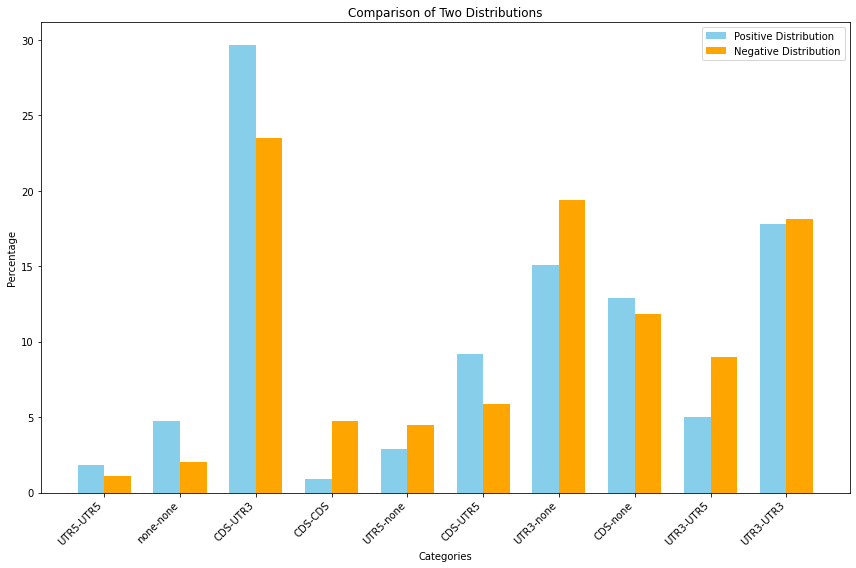

In [30]:
# PLOT 
categories = list(set(df_int['where'].value_counts().index).union(df_neg['where'].value_counts().index))

neg = df_neg['where'].value_counts()
neg = pd.Series([neg.get(key, 0) for key in categories], index=categories)

pos = df_int['where'].value_counts()
pos = pd.Series([pos.get(key, 0) for key in categories], index=categories)

values1 = pos.values

values2 = neg.values

total1 = sum(values1)
total2 = sum(values2)

percentages1 = np.array([value / total1 * 100 for value in values1])
percentages2 = np.array([value / total2 * 100 for value in values2])

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12, 8))
bar1 = ax.bar(index, percentages1, bar_width, label='Positive Distribution', color='skyblue')
bar2 = ax.bar(index + bar_width, percentages2, bar_width, label='Negative Distribution', color='orange')

ax.set_xlabel('Categories')
ax.set_ylabel('Percentage')
ax.set_title('Comparison of Two Distributions')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Train-test-val split

In [48]:
from sklearn.model_selection import train_test_split
import dataset.train_test_val_utils as utils

In [60]:
df_labels = df[['couples', 'interacting']].drop_duplicates().reset_index(drop = True)
assert df_labels.shape[0] == len(df['couples'].unique())
df_labels['interacting'] = df_labels['interacting'].astype('int')


train, test_val = train_test_split(df_labels, test_size=0.3, random_state=0, stratify=df_labels[['interacting']])
test, val = train_test_split(test_val, test_size=0.5, random_state=0, stratify=test_val[['interacting']])

In [65]:
import dataset.train_test_val_utils as utils

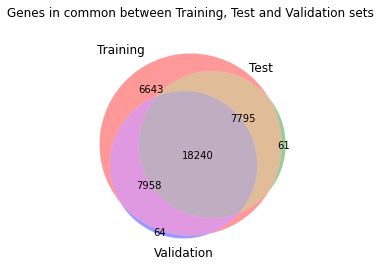

In [66]:
gene_pairs_training = list(set(train.couples))
gene_pairs_test = list(set(val.couples))
gene_pairs_val = list(set(test.couples))
utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)